In [3]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load data
data = pd.read_csv('TESLA.csv')
print(data.head())

# Convert the Date column to timestamp
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].apply(lambda x: x.timestamp())

# Prepare data
data_values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

time_steps = 10
target_column_index = data.columns.get_loc('Close')
X, y = [], []
for i in range(len(scaled_data) - time_steps):
    X.append(scaled_data[i:i + time_steps])
    y.append(scaled_data[i + time_steps, target_column_index])

X, y = np.array(X), np.array(y)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the model with added improvements (Dropout, L2, BatchNormalization, EarlyStopping)
def build_model(learning_rate):
    model = tf.keras.Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train.shape[2]), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Adding dropout
    model.add(BatchNormalization())  # Adding BatchNormalization
    model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))  # Adding dropout again
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the Keras model in KerasRegressor
model = KerasRegressor(model=build_model, verbose=0)

# Define parameter grid for GridSearchCV
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Define GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the model using GridSearchCV
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Print the best parameters
print(f'Best parameters found: {grid_result.best_params_}')

# Get the best model
best_model = grid_result.best_estimator_.model_

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)  # Exponential decay

lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model
history = best_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'],
                         batch_size=grid_result.best_params_['batch_size'],
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on test data
test_loss = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict and inverse scale predictions
def inverse_transform(y_scaled, original_data_shape):
    extended_data = np.zeros((y_scaled.shape[0], original_data_shape[1]))
    extended_data[:, target_column_index] = np.squeeze(y_scaled)
    return scaler.inverse_transform(extended_data)[:, target_column_index]

y_test_rescaled = inverse_transform(y_test, scaled_data.shape)
y_pred_rescaled = inverse_transform(best_model.predict(X_test), scaled_data.shape)

         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500


2024-12-27 21:00:30.732952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-27 21:00:30.735181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-27 21:00:30.737370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Best parameters found: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001}
Epoch 1/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0010 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0013 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0011 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0015 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0011 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/50
56/56 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 9.6117e-04 - lr: 0.0010
Epoch 9/50
56/56 

2024-12-27 21:23:01.625924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-27 21:23:01.627370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-27 21:23:01.628392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

19/19 [==============================] - 1s 3ms/step


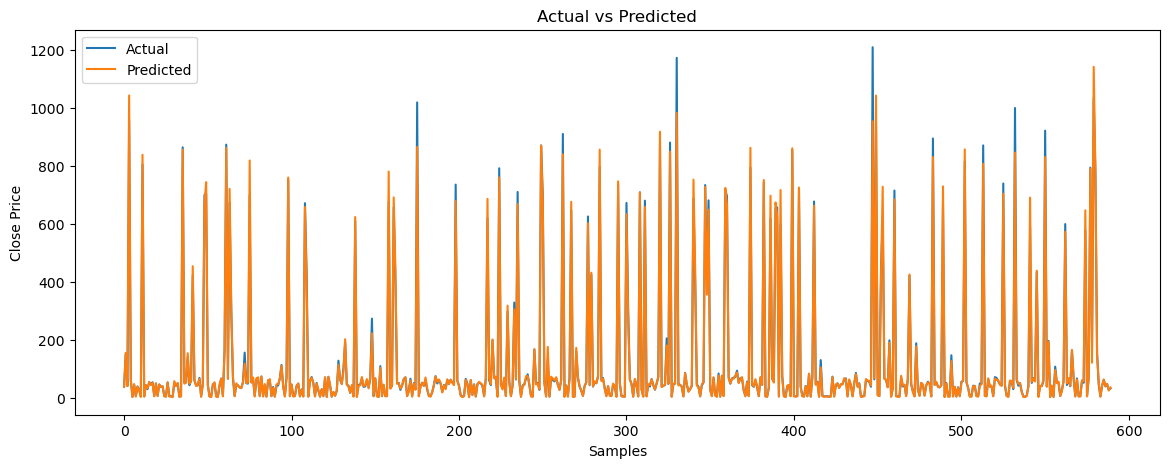

In [5]:
# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.show()

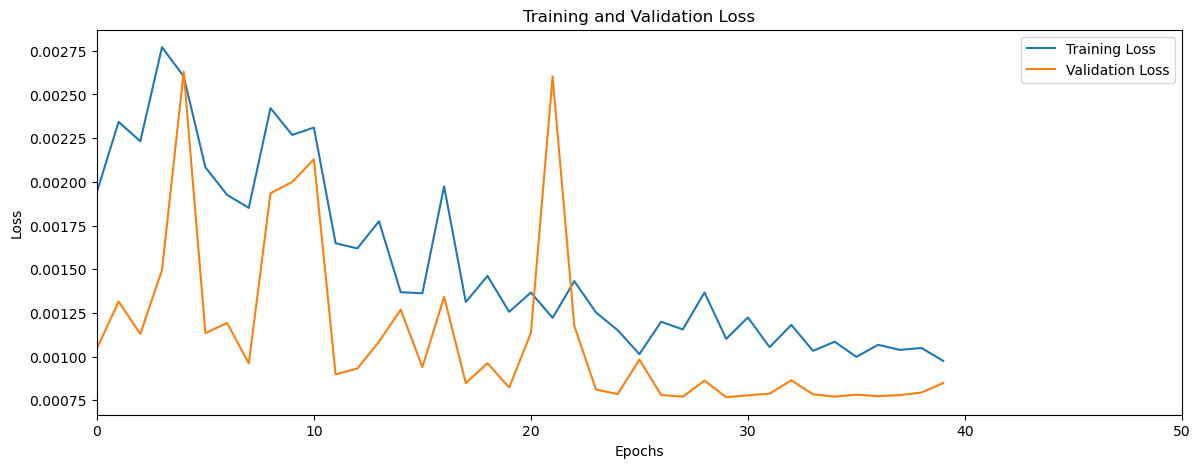

In [7]:
# Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(0, grid_result.best_params_['epochs'])
plt.legend()
plt.show()